In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
import itertools
import warnings

import matplotlib.pyplot as plt
from matplotlib.collections import PathCollection
from matplotlib.legend_handler import HandlerPathCollection, HandlerLine2D

from kalman_reconstruction.kalman import (
    Kalman_SEM,
)
from reconstruct_climate_indices.idealized_ocean import (
    AMO_oscillatory_ocean
)
from reconstruct_climate_indices.track_data import (
    track_model
)
from tqdm import tqdm

In [105]:
SUBDATA_PATH = "AMO_oscillator"
PATH_FIGURES = Path("../results/AMO_oscillator")
SAVE_FIGURES = True


def save_fig(fig, relative_path, **kwargs):
    if SAVE_FIGURES:
        fig.savefig(PATH_FIGURES / relative_path, **kwargs)
    else:
        pass

In [106]:
plt.rcParams["figure.figsize"] = (10, 8)
# Set default matplotlib style
MEDIUM_SIZE = 12
BIGGER_SIZE = 15
HUGHER_SIZE = 18
plt.style.use("seaborn-v0_8-whitegrid")
# plt.style.use('dark_background')

plt.rcParams["figure.figsize"] = (10.0, 6.0)
plt.rc("font", size=MEDIUM_SIZE)  # controls default text sizes
plt.rc("figure", titlesize=HUGHER_SIZE)  # fontsize of the axes title
plt.rc("figure", labelsize=BIGGER_SIZE)  # fontsize of the x and y labels
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc(
    "axes.spines",
    **dict(
        left=True,
        right=False,
        bottom=True,
        top=False,
    )
)
# fontsize of the x and y labels
plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("legend", loc="upper right")
# use colorblind save colors https://davidmathlogic.com/colorblind
colors = [
    "#CC6677",
    "#6E9CB3",
    "#CA8727",
    "#44AA99",
    "#AA4499",
    "#D6BE49",
    "#A494F5",
]
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=colors)


def plot_colors(colors):
    fig, axs = plt.subplots(figsize=(5, 1))
    for idx, color in enumerate(colors):
        axs.scatter(idx, 1, c=color, s=300)

    axs.set_yticks([])
    return fig, axs

In [107]:
def product_dict(**kwargs):
    keys = kwargs.keys()
    for instance in itertools.product(*kwargs.values()):
        yield dict(zip(keys, instance))

In [108]:
dt = 30
default_settings = dict(
    nt=3000,
    dt=dt,
    per0=24*365.25,
    tau0=10*365.25,
    dNAO=0.1,
    dEAP=0.1,
    cNAOvsEAP=0,
    save_path=None,
    return_settings=True,
)

data = track_model(_func=AMO_oscillatory_ocean, func_kwargs=default_settings, subdata_path = SUBDATA_PATH)
data

<xarray.Dataset>
Dimensions:     (time: 3000, dEAP: 1, dNAO: 1, cNAOvsEAP: 1)
Coordinates:
  * time        (time) float64 0.0 30.0 60.0 ... 8.991e+04 8.994e+04 8.997e+04
    time_years  (time) float64 0.0 0.08214 0.1643 0.2464 ... 246.2 246.2 246.3
  * dEAP        (dEAP) float64 0.1
  * dNAO        (dNAO) float64 0.1
  * cNAOvsEAP   (cNAOvsEAP) int32 0
Data variables:
    NAO         (time, dEAP, dNAO, cNAOvsEAP) float64 0.0 0.004348 ... -0.01128
    EAP         (time, dEAP, dNAO, cNAOvsEAP) float64 0.0 0.01482 ... 0.005955
    ZOT         (time, dEAP, dNAO, cNAOvsEAP) float64 0.0 0.0 ... -0.7374
    AMO         (time, dEAP, dNAO, cNAOvsEAP) float64 0.0 0.0 ... 0.03895
Attributes:
    coder:    Florian Sévellec <florian.sevellec@univ-brest.fr>

In [109]:
# make sure to get a kind of random seed
seed = np.random.default_rng(seed=2349832653).integers(0, 1e12, 1)
variance_unobs_comp = 1
random_generator = np.random.default_rng(seed=seed)

data["random_variable"] = (
    ["time"], 
    random_generator.normal(
        loc=0, 
        scale=variance_unobs_comp, 
        size=len(data.time)
        )
)
iselect_dict = dict(
    dEAP = 0,
    dNAO = 0,
    cNAOvsEAP = 0,
)

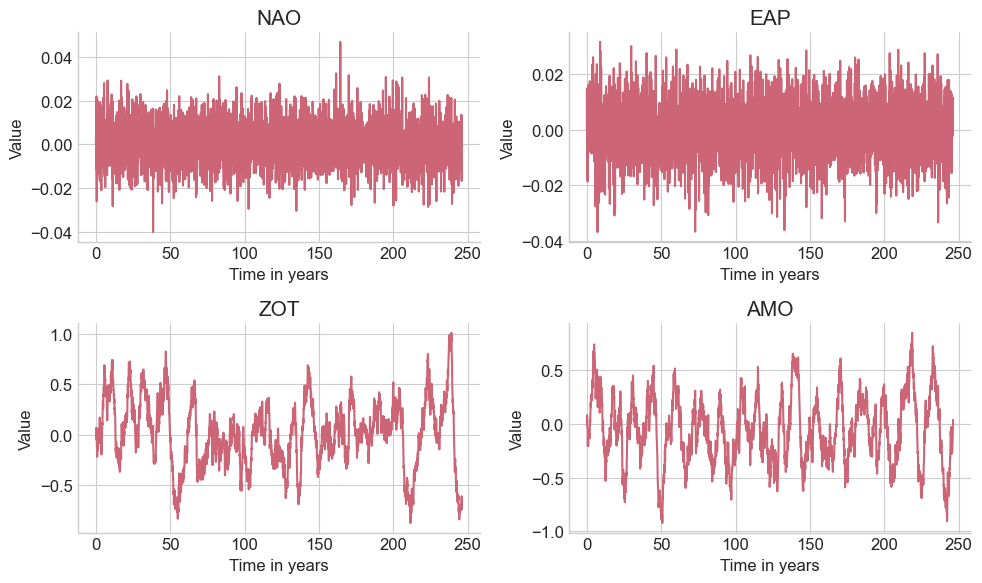

In [110]:
fig, axs = plt.subplots(nrows=2, ncols=2)
axs_flat = axs.flatten()
for idx, var in enumerate(["NAO", "EAP", "ZOT", "AMO"]) :
    data[var].plot(
        ax = axs_flat[idx], 
        x = "time_years")
    axs_flat[idx].set_title(var)
    axs_flat[idx].set_xlabel("Time in years")
    axs_flat[idx].set_ylabel("Value")
    
fig.tight_layout()
save_fig(fig, "Evolution.png", dpi = 400)

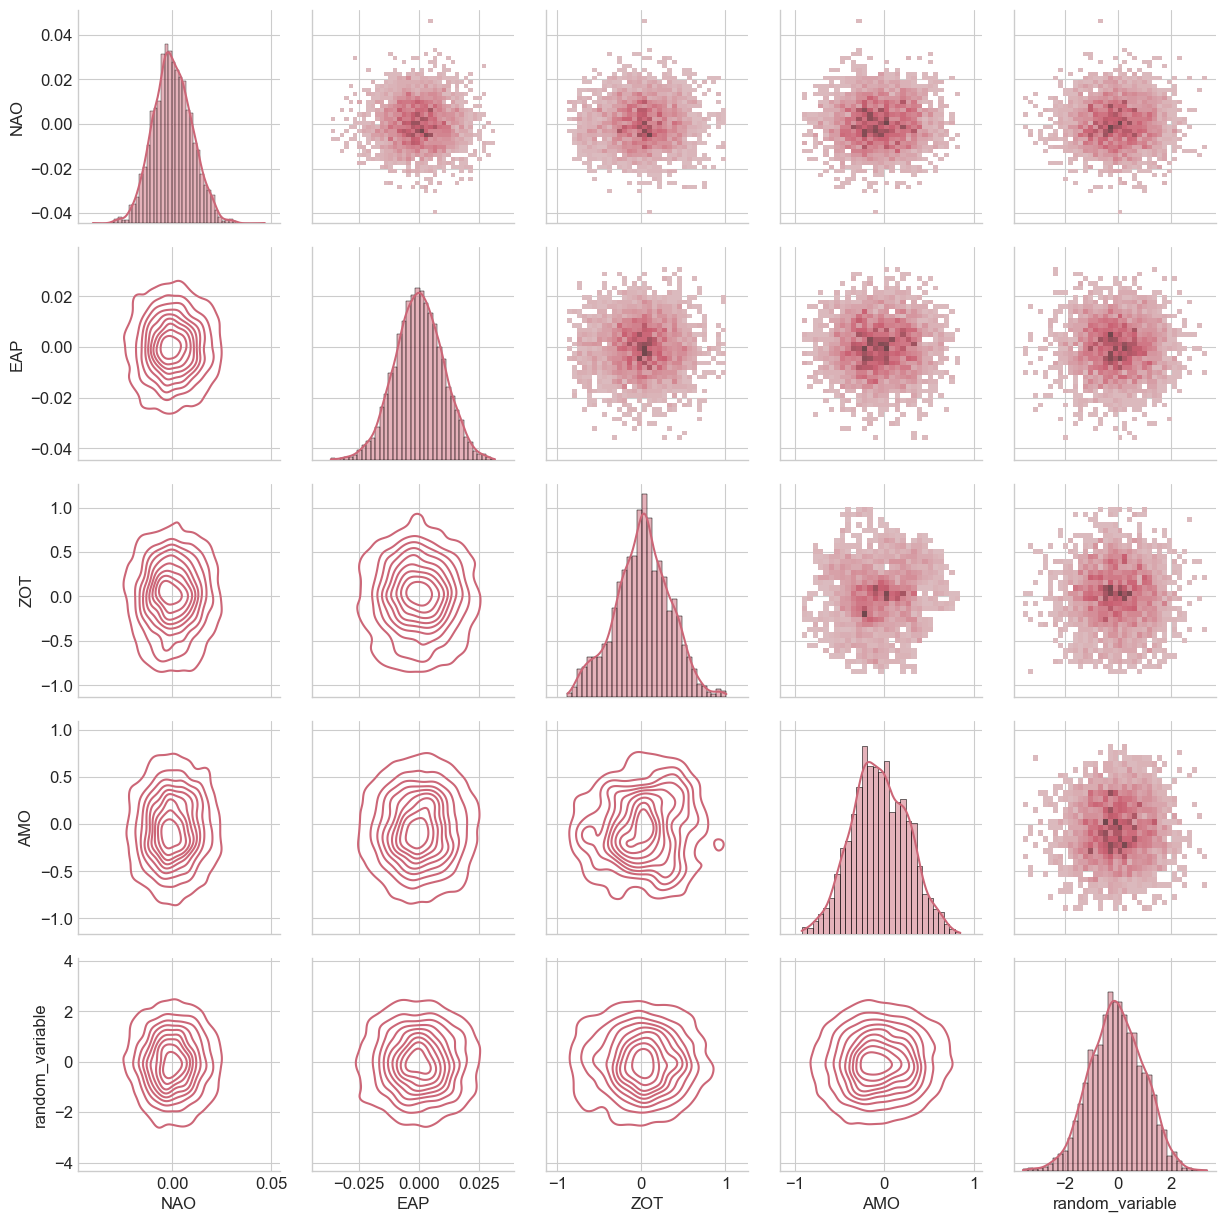

In [113]:
import seaborn as sns

df = data.isel(iselect_dict).drop(["dNAO", "dEAP", "cNAOvsEAP", "time_years"]).to_dataframe()
g = sns.PairGrid(df)
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=False)
g.map_diag(sns.histplot, kde=True)
save_fig(g, "CorrelationMap.png", dpi = 400)

Code to run the Kalman Itteration for all experiments

In [114]:
# variance of the random white noise of z
variance_unobs_comp = 1

# variance of the observation error used in Kalman
variance_obs_comp = 0.0001

# number of SEM iterations
nb_iter_SEM = 50

Create Dataset for kalman_results

In [126]:
var_name = lambda key, krn : f"{key}{krn}"

data_kalman = xr.Dataset({})
data_kalman = data_kalman.assign_coords(dict(kalman_iteration = np.arange(nb_iter_SEM)))
data_kalman["kalman_loglike"] = (["kalman_iteration"], np.zeros_like(data_kalman.kalman_iteration) * np.nan)
kalman_result_names = ["_kalman_state", "_kalman_prob"]
store = ["NAO", "AMO", "ZOT", "random_variable"]
for key in store:
    for krn in kalman_result_names:
        data_kalman[var_name(key, krn)] = xr.DataArray(coords=data.coords)


In [128]:
def run_Kalman_SEM(y0, y1, y2, z1):
    # state
    y = np.array([y0, y1, y2]).T
    x = np.array([y0, y1, y2, z1]).T

    # shapes
    n = np.shape(x)[1]
    p = np.shape(y)[1]

    # kalman parameters
    H = np.append(np.eye(p), np.zeros((p, n)), axis=1)[:, 0:n]
    R = variance_obs_comp * np.eye(p)

    # stochastic EM
    return Kalman_SEM(x, y, H, R, nb_iter_SEM)



iselect_dict = dict(
    dEAP = 0,
    dNAO = 0,
    cNAOvsEAP = 0,
)

y0 = data["NAO"].isel(iselect_dict).values.flatten()
y1 = data["AMO"].isel(iselect_dict).values.flatten()
y2 = data["ZOT"].isel(iselect_dict).values.flatten()
z1 = data.random_variable
(
    kalman_state,
    kalman_prob,
    M,
    kalman_loglik,
    x,
    x_f,
    Q,
) = run_Kalman_SEM(y0, y1, y2, z1)

100%|██████████| 50/50 [00:55<00:00,  1.12s/it]


In [129]:
data_kalman["kalman_loglike"] = xr.DataArray(
                data=kalman_loglik,
                dims=["kalman_iteration"],
                coords=dict(
                    kalman_iteration=data_kalman.kalman_iteration,
                ),
            )

for idx, key in enumerate(store):
    for krn, temp in zip(kalman_result_names, [kalman_state, kalman_prob]) :
# Store the State results
        if np.ndim(temp) == 2:
            data_kalman[var_name(key, krn)][
                iselect_dict
            ] = xr.DataArray(
                data=temp[:, idx],
                dims=["time"],
                coords=dict(
                    time=data_kalman.time,
                ),
            )
# Store the Prob. results
        elif np.ndim(temp) == 3:
            data_kalman[var_name(key, krn)][
                iselect_dict
            ] = xr.DataArray(
                data=temp[:, idx, idx],
                dims=["time"],
                coords=dict(
                    time=data_kalman.time,
                ),
            )
        else:
            pass

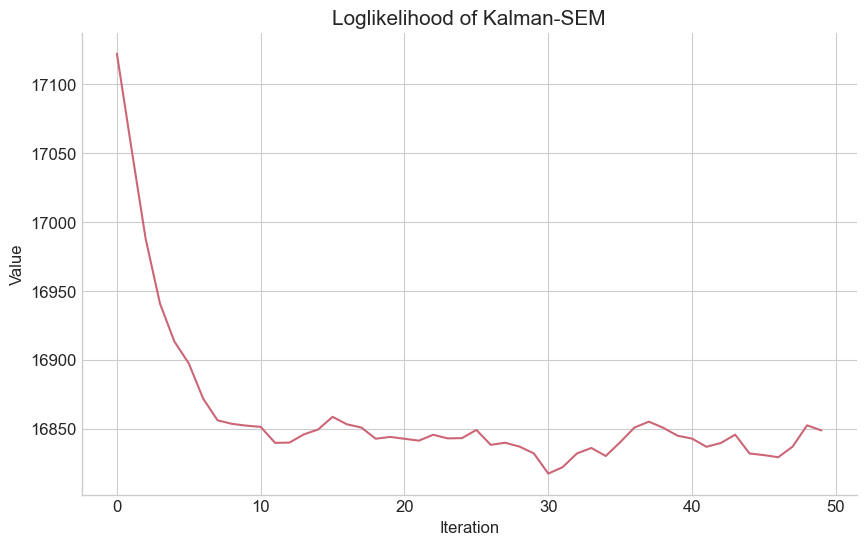

In [130]:
fig, ax = plt.subplots(1,1)
data_kalman.kalman_loglike.plot(ax = ax, x= "kalman_iteration")
ax.set_ylabel("Value")
ax.set_xlabel("Iteration")
ax.set_title("Loglikelihood of Kalman-SEM")
save_fig(fig, "Loglikelihood.png", dpi = 400)

In [142]:
def plot_state_prob(ax, x_value, state, prob, ci = 1.96, line_kwargs = {}, fill_kwargs=dict(alpha = 0.3, label = None)):
    p = ax.plot(x_value, state, **line_kwargs)
    ax.fill_between(
        x_value,
        state - ci * np.sqrt(prob),
        state + ci * np.sqrt(prob),
        color = p[0].get_color(),
        **fill_kwargs
    )



In [147]:
time_slice = data_kalman.time[data_kalman.time_years < 100] # in years

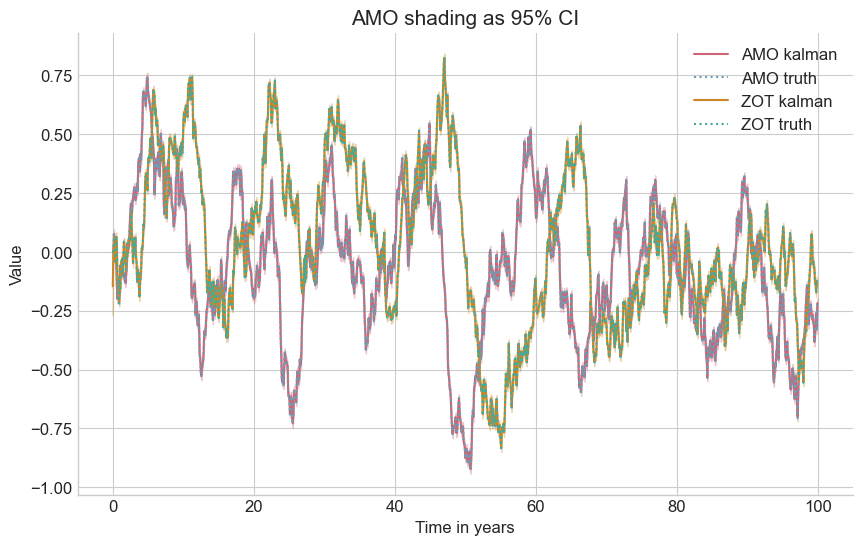

In [148]:
fig, ax = plt.subplots(1,1)
if "AMO" in store:
    plot_state_prob(ax = ax,
        x_value = data_kalman.time_years.sel(time = time_slice),
        state = data_kalman.AMO_kalman_state.sel(time = time_slice).values.flatten(),
        prob = data_kalman.AMO_kalman_prob.sel(time = time_slice).values.flatten(),
        line_kwargs = dict(label = "AMO kalman"),
    )
    data.AMO.sel(time = time_slice).plot(ax = ax, x= "time_years",label = "AMO truth", linestyle = ":")
else : pass
if "ZOT" in store:
    plot_state_prob(ax = ax,
        x_value = data_kalman.time_years.sel(time = time_slice),
        state = data_kalman.ZOT_kalman_state.sel(time = time_slice).values.flatten(),
        prob = data_kalman.ZOT_kalman_prob.sel(time = time_slice).values.flatten(),
        line_kwargs = dict(label = "ZOT kalman"),
    )
    data.ZOT.sel(time = time_slice).plot(ax = ax, x= "time_years",label = "ZOT truth", linestyle = ":")
else : pass

ax.legend()
ax.set_ylabel("Value")
ax.set_xlabel("Time in years")
ax.set_title("AMO shading as 95% CI")
save_fig(fig, "AMO_reconstruction.png", dpi = 400)

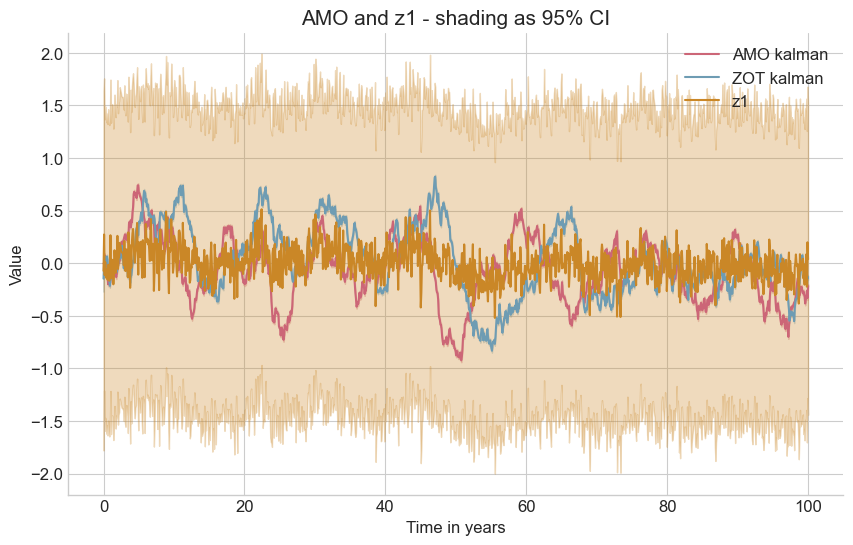

In [149]:
fig, ax = plt.subplots(1,1)

if "AMO" in store:
    plot_state_prob(ax = ax,
        x_value = data_kalman.time_years.sel(time = time_slice),
        state = data_kalman.AMO_kalman_state.sel(time = time_slice).values.flatten(),
        prob = data_kalman.AMO_kalman_prob.sel(time = time_slice).values.flatten(),
        line_kwargs = dict(label = "AMO kalman"),
    )
else : pass
if "ZOT" in store:
    plot_state_prob(ax = ax,
        x_value = data_kalman.time_years.sel(time = time_slice),
        state = data_kalman.ZOT_kalman_state.sel(time = time_slice).values.flatten(),
        prob = data_kalman.ZOT_kalman_prob.sel(time = time_slice).values.flatten(),
        line_kwargs = dict(label = "ZOT kalman"),
    )
else : pass
plot_state_prob(ax = ax,
    x_value = data_kalman.time_years.sel(time = time_slice),
    state = data_kalman.random_variable_kalman_state.sel(time = time_slice).values.flatten(),
    prob = data_kalman.random_variable_kalman_prob.sel(time = time_slice).values.flatten(),
    line_kwargs = dict(label = "z1"),
)
ax.legend()
ax.set_ylabel("Value")
ax.set_xlabel("Time in years")
ax.set_title("AMO and z1 - shading as 95% CI")
save_fig(fig, "AMO_and_z1.png", dpi = 400)

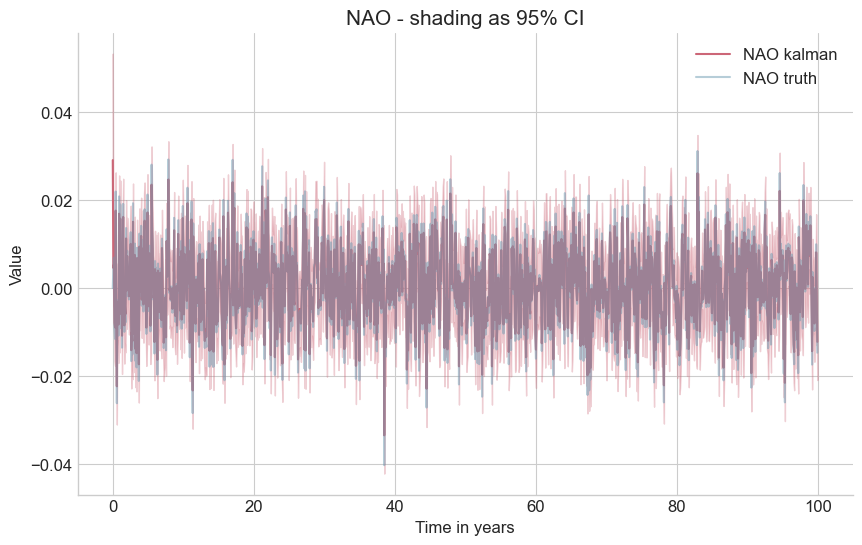

In [150]:
fig, ax = plt.subplots(1,1)
if "NAO" in store:
    plot_state_prob(ax = ax,
        x_value = data_kalman.time_years.sel(time = time_slice),
        state = data_kalman.NAO_kalman_state.sel(time = time_slice).values.flatten(),
        prob = data_kalman.NAO_kalman_prob.sel(time = time_slice).values.flatten(),
        line_kwargs = dict(label = "NAO kalman"),
    )
    data.NAO.sel(time = time_slice).plot(ax = ax, x= "time_years", alpha = 0.5, label = "NAO truth")
else : pass
if "EAP" in store:
    plot_state_prob(ax = ax,
        x_value = data_kalman.time_years.sel(time = time_slice),
        state = data_kalman.EAP_kalman_state.sel(time = time_slice).values.flatten(),
        prob = data_kalman.EAP_kalman_prob.sel(time = time_slice).values.flatten(),
        line_kwargs = dict(label = "EAP kalman"),
    )
    data.EAP.sel(time = time_slice).plot(ax = ax, x= "time_years", alpha = 0.5, label = "EAP truth")
else : pass


ax.set_ylabel("Value")
ax.set_xlabel("Time in years")
ax.set_title("NAO - shading as 95% CI")
ax.legend()

save_fig(fig, "NAO_kalman.png", dpi = 400)

Plot Correlation Maps for the result

In [151]:
import seaborn as sns

df = data.isel(iselect_dict).drop(["dNAO", "dEAP", "cNAOvsEAP", "time_years"]).to_dataframe()
df_kalman = data_kalman.isel(iselect_dict).drop(
    ["kalman_loglike", "kalman_iteration"]).drop(
    ["dNAO", "dEAP", "cNAOvsEAP", "time_years"]).drop(
    ["NAO_kalman_prob", "AMO_kalman_prob", "random_variable_kalman_prob"]
    ).to_dataframe()
df_all = pd.concat([df, df_kalman], ignore_index=False, sort=False, axis=1)

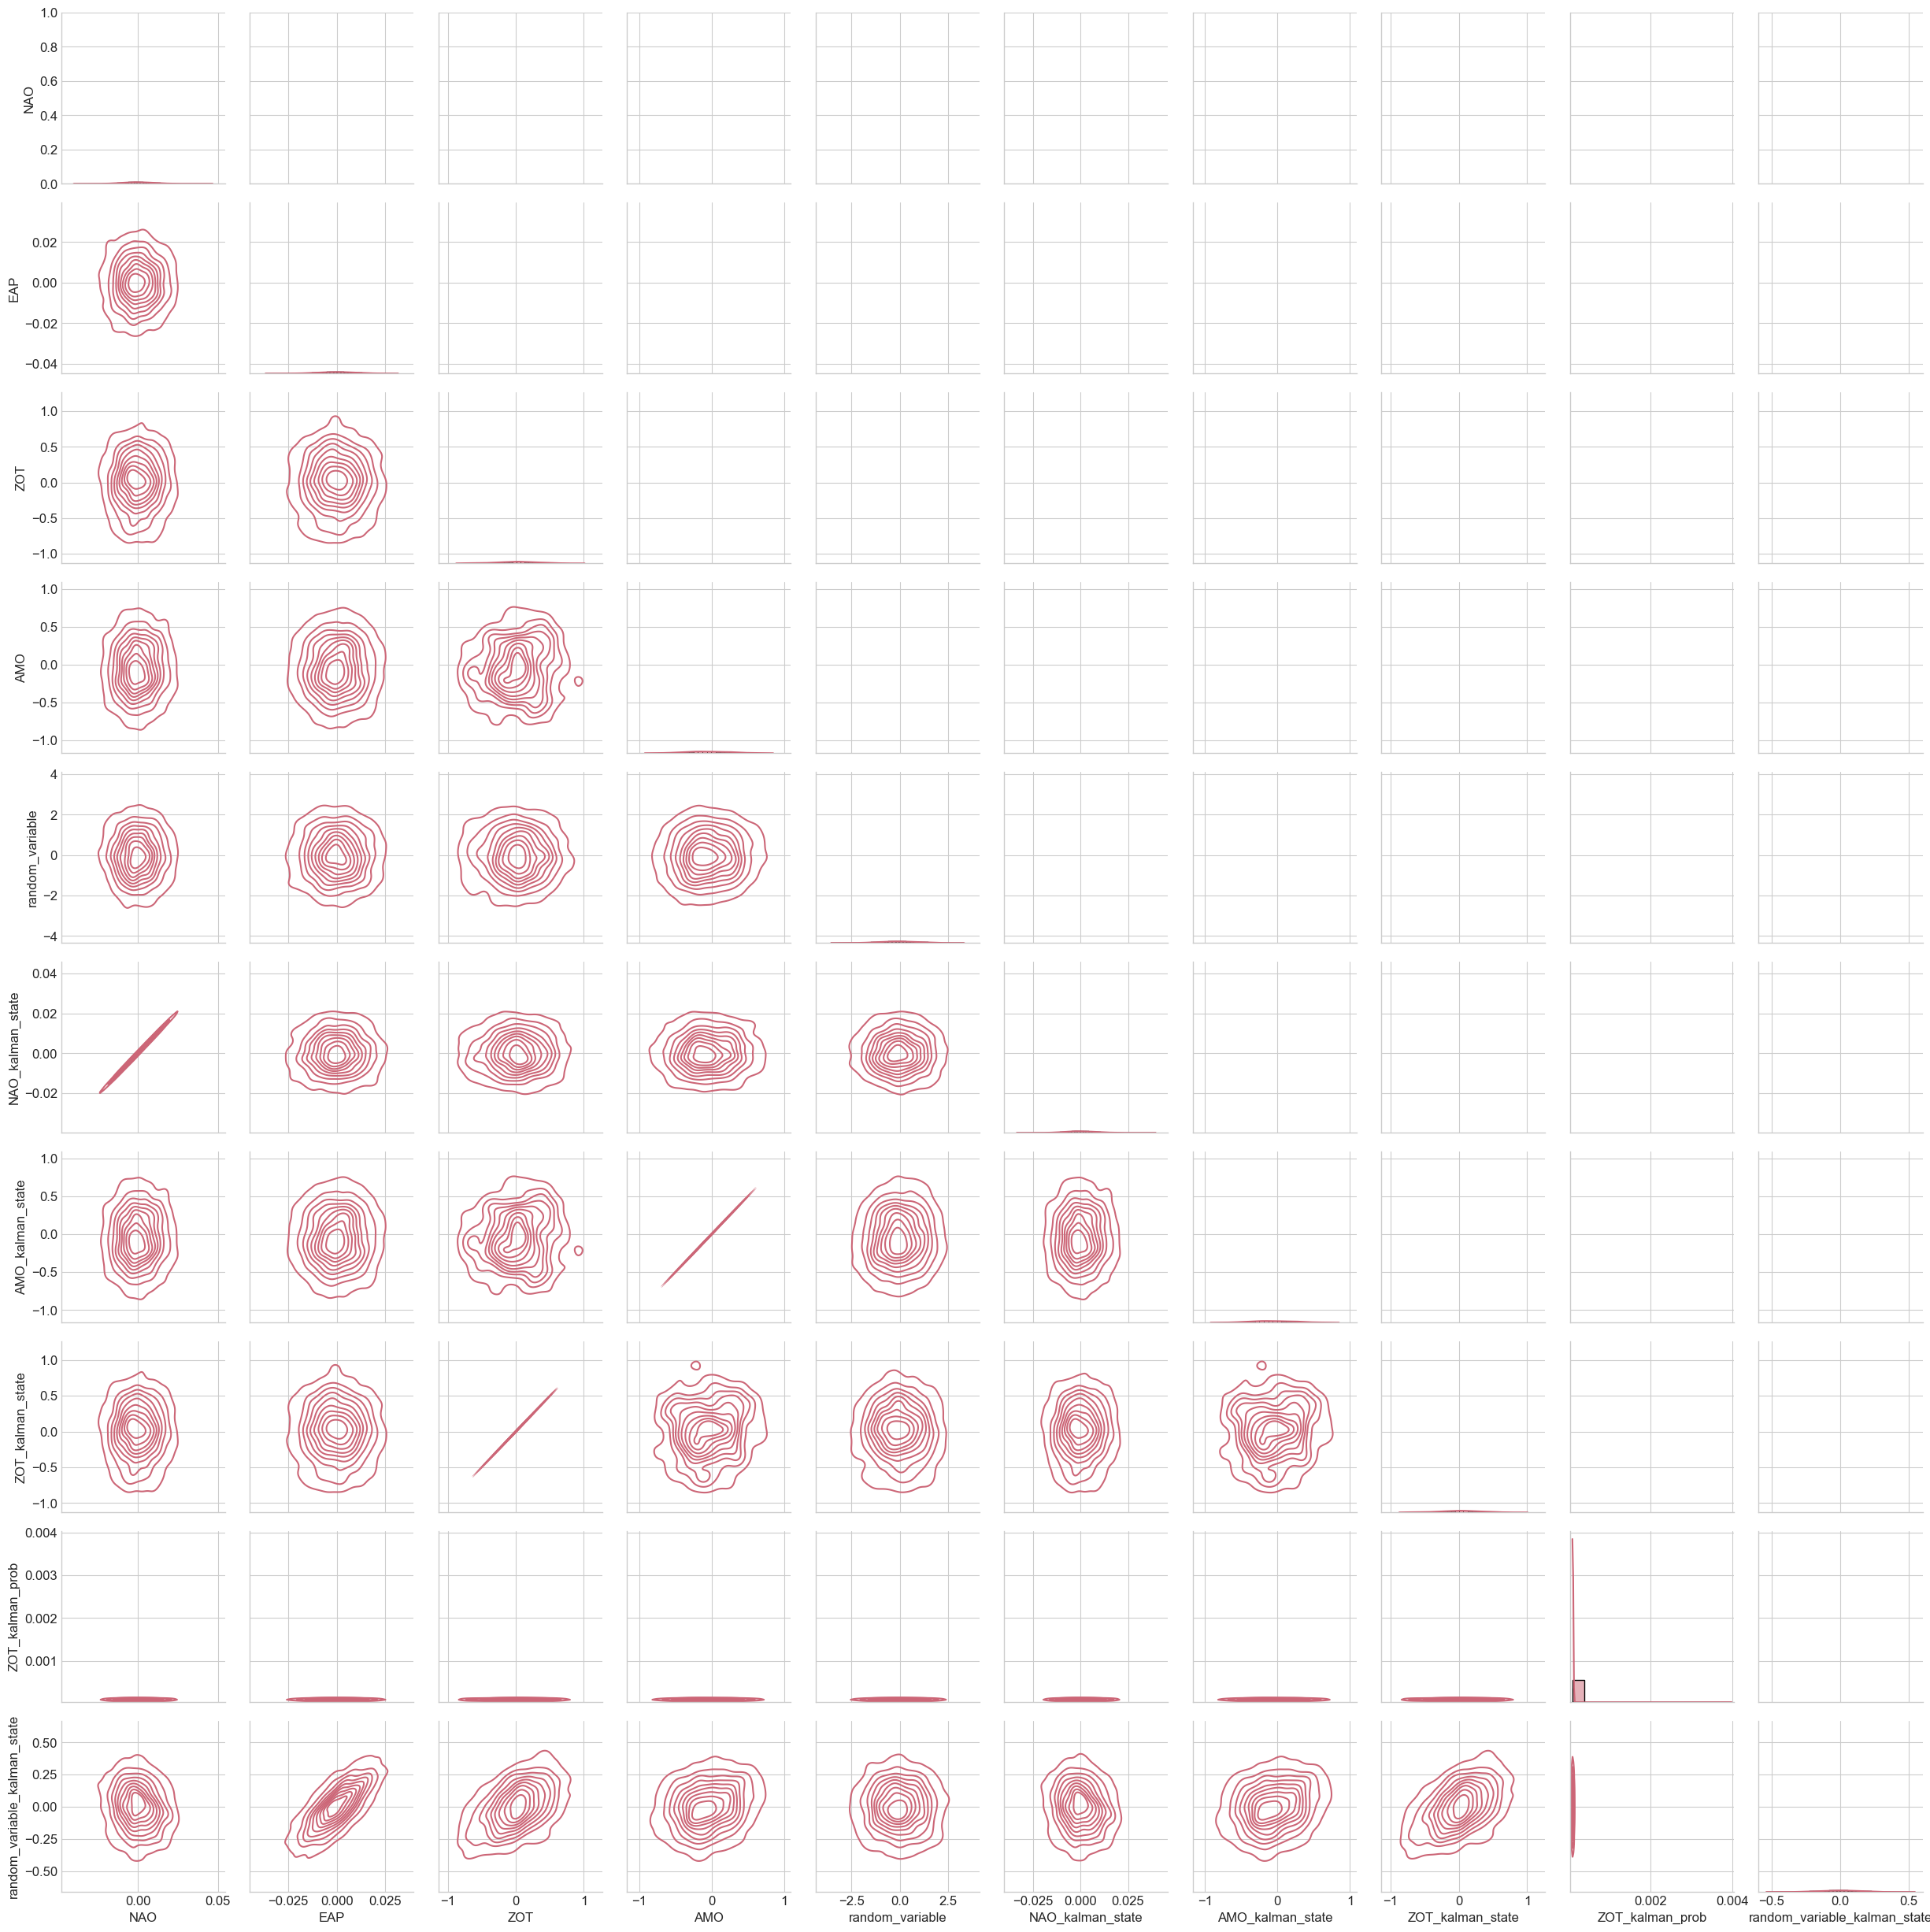

In [152]:
g = sns.PairGrid(df_all)
# g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=False)
g.map_diag(sns.histplot, kde=True)
save_fig(g, "correlation_kalman_applied.png", dpi = 400)